# Stroke Classification

The dataset can be found [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)

In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [242]:
# !pip install pandas_profiling

### Notes:

- binary classification problem
- going to throw some popular off the shelf models: RF, XGB, KNN, SVC
- emphasize best practices in analysis on new-domain datasets and packaging the training & serving the models in pipelines, transformers.

## Data Understanding

In [243]:
df = pd.read_csv("data/healthcare-dataset-stroke-data.csv")

In [244]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


### To Do:
- binary classification - check for class imbalance in the response
- treat missing values
- spot patterns in the data with regard to the response
- examine features distributions
- check for interesting interactions between features
- check for possible need for encoding (dummying, labeling)

In [246]:
from pandas_profiling import ProfileReport

In [247]:
profile = ProfileReport(df, title="Analysis of the data")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Notes:

- some of the binary and all of the categorical variables need to be label-encoded
- categorical variables need to be dummy-encoded
- missing values in bmi, not many, probably ok to drop
- some possible interactions between age & bmi, bmi & avg_glucose and age & avg_glucose
- no overwhelming correlation between any feature and the response
- treat for imbalance in the response after split to train and test

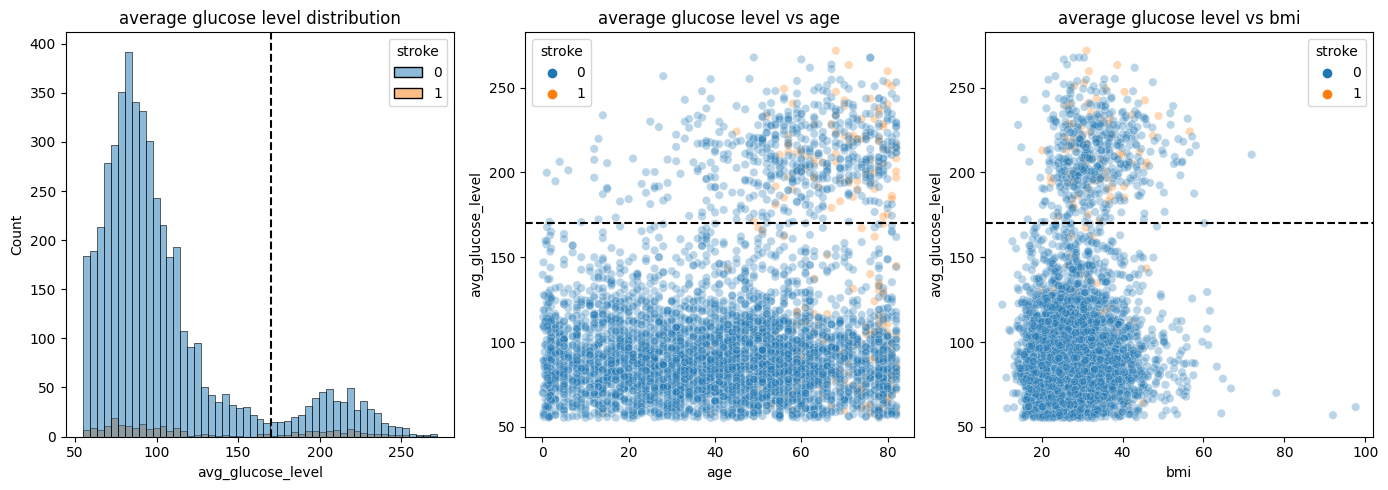

In [248]:
plt.figure(figsize=(14,5))

plt.subplot(1, 3, 1)
plt.title('average glucose level distribution')
sns.histplot(x=df.avg_glucose_level, hue=df.stroke)
plt.axvline(x=170, linestyle="--", color='black')

plt.subplot(1, 3, 2)
plt.title('average glucose level vs age')
sns.scatterplot(data=df, x='age', y='avg_glucose_level', hue='stroke', alpha=0.3)
plt.axhline(y=170, linestyle="--", color='black')

plt.subplot(1, 3, 3)
plt.title('average glucose level vs bmi')
sns.scatterplot(data=df, x='bmi', y='avg_glucose_level', hue='stroke', alpha=0.3)
plt.axhline(y=170, linestyle="--", color='black')

plt.tight_layout()

Note that we seem to have 2 distinct groups, probably related to diabetes status, which is not part of the data. Though it doesn't show in the distribution of avg_glucose_level, there might be a connection between diabetes and the probability of a stroke, which could be augmented by those interactions and could possibly be more visible with more balanced classes.

## Data Preprocessing

In [249]:
# preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler

#### Drop outlier categories

In [250]:
df = (
    df[df.gender != 'Other']
    .drop('id', axis=1)
    .dropna() # only removes bmi ...
    )

y = df.iloc[:, -1]
X = df.iloc[:, :-1]

#### divide the features by type

In [251]:
continous = ['age', 'avg_glucose_level', 'bmi']
#binary=['gender', 'ever_married', 'Residence_type']
categorical = (X
    .drop(continous, axis=1)
    #.drop(binary, axis=1)
    .columns.to_list())

print(continous, categorical)

['age', 'avg_glucose_level', 'bmi'] ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [252]:
preproc = ColumnTransformer(transformers=[
            #('missing_imputing', SimpleImputer(strategy='median'), ['bmi']),
            ("scaling", StandardScaler(), continous),
            ("one_hot_encoding", OneHotEncoder(), categorical)
            ])
            
preproc

ColumnTransformer(transformers=[('scaling', StandardScaler(),
                                 ['age', 'avg_glucose_level', 'bmi']),
                                ('one_hot_encoding', OneHotEncoder(),
                                 ['gender', 'hypertension', 'heart_disease',
                                  'ever_married', 'work_type', 'Residence_type',
                                  'smoking_status'])])

#### Split to train/test

In [253]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

In [254]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3926, 10) (982, 10) (3926,) (982,)


#### Oversample the minority class in the response

In [255]:
# print the ratio of the stroke values (0, 1)
round(y.value_counts()/([len(y)]*2), 2)


0    0.96
1    0.04
Name: stroke, dtype: float64

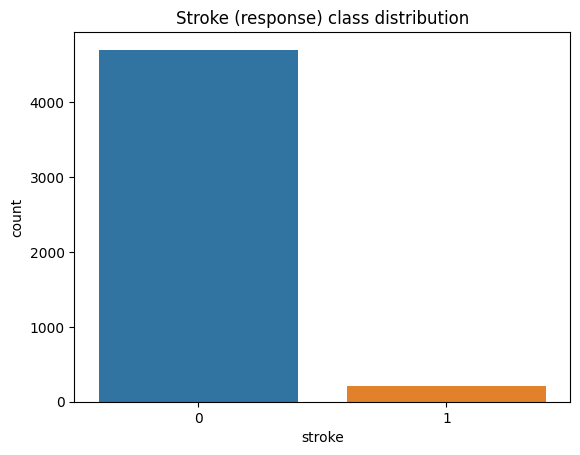

In [256]:
g = sns.countplot(x=y)
g.set(title="Stroke (response) class distribution")
plt.show(g)

In [257]:
resamp = RandomOverSampler()
X_train_bal, y_train_bal = resamp.fit_resample(X_train, y_train)


In [258]:
y_train_bal.value_counts()

0    3760
1    3760
Name: stroke, dtype: int64

## Modelling

In [259]:
# modelling
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import NotFittedError

In [260]:
pipelines = {
    'rf': make_pipeline(preproc, RandomForestClassifier(random_state=1234)),
    'gb': make_pipeline(preproc, GradientBoostingClassifier(random_state=1234)),
    'knn': make_pipeline(preproc, KNeighborsClassifier())
}

In [261]:
hypergrid = {
    'rf': {
        'randomforestclassifier__min_samples_split': [2, 4, 6],
        'randomforestclassifier__min_samples_leaf': [1, 2, 3],
        'randomforestclassifier__bootstrap': ['True', 'False']
    },
    'gb':{
        'gradientboostingclassifier__min_samples_split': [2, 4, 6],
        'gradientboostingclassifier__min_samples_leaf': [1, 2, 3],
        'gradientboostingclassifier__learning_rate': [1, 0.5, 0.25, 0.1, 0.05, 0.01]
    },
    'knn':{
        'kneighborsclassifier__n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10]
    }
}

In [282]:
fit_models = {}

for algo, pipe in pipelines.items():
    model = GridSearchCV(pipe, hypergrid[algo], cv=10, n_jobs=-1)
    
    try:
        print(f'--- starting training for {algo} ---')
        model.fit(X_train_bal, y_train_bal)
        fit_models[algo] = model
        print(f'best_accuracy = {round(model.best_score_, 2)}')
        print(f'best_param = {model.best_params_}')
        print(f'--- {algo} has been successfully fit ---')

    except NotFittedError as e:  # specific exception for sklearn models
        print(repr(e))

--- starting training for rf ---
best_accuracy = 1.0
best_param = {'randomforestclassifier__bootstrap': 'True', 'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__min_samples_split': 6}
--- rf has been successfully fit ---
--- starting training for gb ---
best_accuracy = 0.97
best_param = {'gradientboostingclassifier__learning_rate': 1, 'gradientboostingclassifier__min_samples_leaf': 1, 'gradientboostingclassifier__min_samples_split': 2}
--- gb has been successfully fit ---
--- starting training for knn ---
best_accuracy = 0.96
best_param = {'kneighborsclassifier__n_neighbors': 3}
--- knn has been successfully fit ---


In [283]:
fit_models

{'rf': GridSearchCV(cv=10,
              estimator=Pipeline(steps=[('columntransformer',
                                         ColumnTransformer(transformers=[('scaling',
                                                                          StandardScaler(),
                                                                          ['age',
                                                                           'avg_glucose_level',
                                                                           'bmi']),
                                                                         ('one_hot_encoding',
                                                                          OneHotEncoder(),
                                                                          ['gender',
                                                                           'hypertension',
                                                                           'heart_disease',
                   

## Evaluation

In [266]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

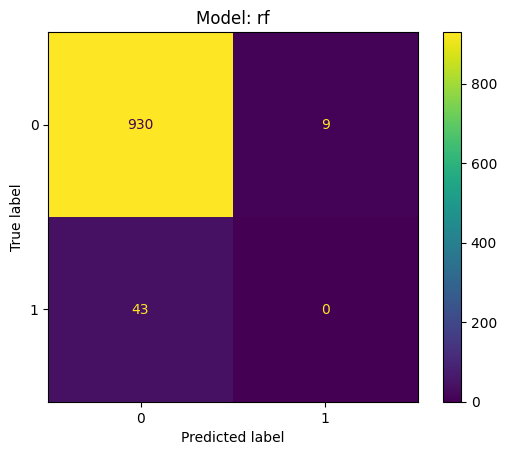

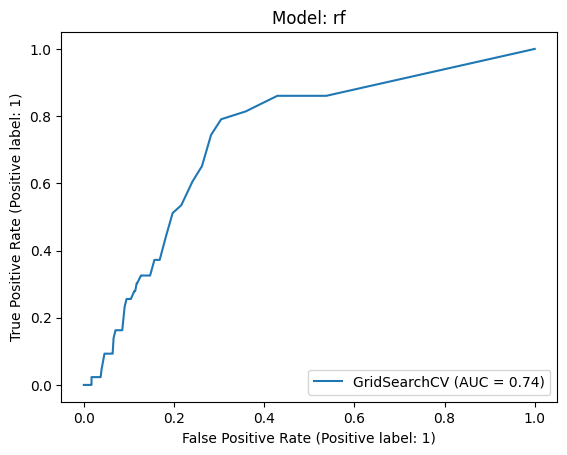

rf scores: 
        Accuracy: 0.947,        Precision: 0.0,        Recall: 0.0,        F1: 0.0,        AUC: 0.739


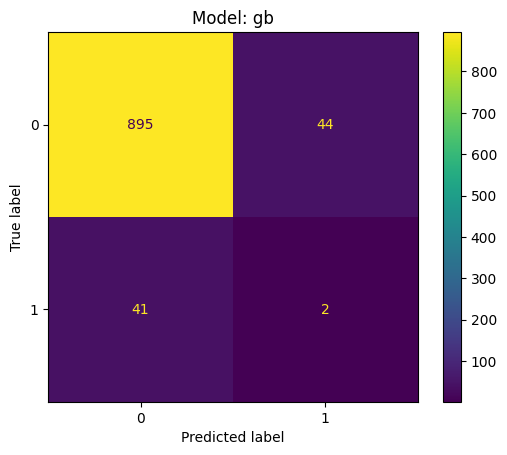

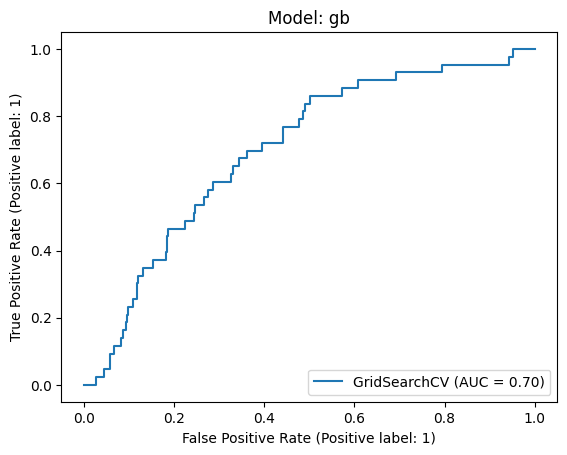

gb scores: 
        Accuracy: 0.913,        Precision: 0.043,        Recall: 0.047,        F1: 0.045,        AUC: 0.7


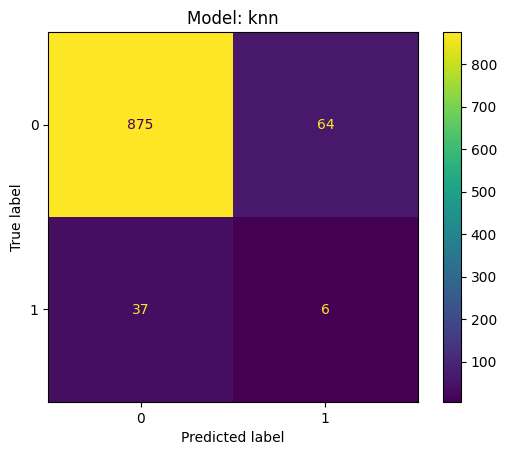

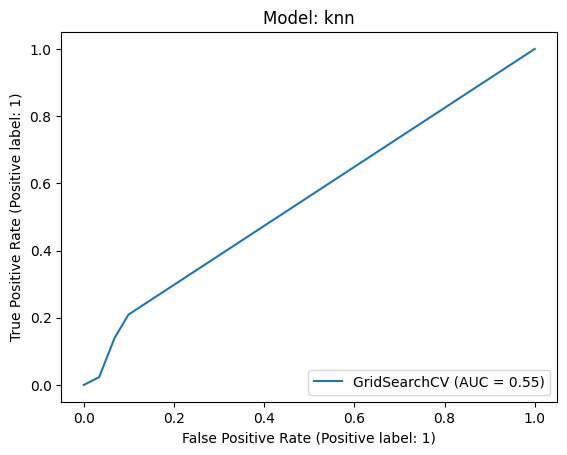

knn scores: 
        Accuracy: 0.897,        Precision: 0.086,        Recall: 0.14,        F1: 0.106,        AUC: 0.553


In [281]:
for algo, model in fit_models.items():
    
    y_pred = model.predict(X_test)
    y_pred_prob = model.predict_proba(X_test)[:, 1]

    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
    plt.title(f'Model: {algo}')

    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title(f'Model: {algo}')

    plt.show()

    print(f'{algo} scores: \n\
        Accuracy: {round(accuracy_score(y_test, y_pred), 3)},\
        Precision: {round(precision_score(y_test, y_pred), 3)},\
        Recall: {round(recall_score(y_test, y_pred), 3)},\
        F1: {round(f1_score(y_test, y_pred), 3)},\
        AUC: {round(roc_auc_score(y_test, y_pred_prob), 3)}'
    )